In [ ]:
# NOTES

# We are working on Bandwidth prediction model
# our data is "ts" -> time in epcoh , "bandwidth" -> in bits per sec
# We have sourced this subset of data internally
# cleanse the data where possible
# there are some data holes, which are the issue of collection, which you will see is reflected in visualization graph
# as we proceed we are working with Data collection team to address them where ever possible


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

% matplotlib inline

plt.rcParams['figure.figsize'] = (16.0, 8.0)
pd.set_option('display.precision',9)

In [80]:
bw = pd.read_csv('./bw_data.csv')
bw.head()
# you will notice that data is not sorted out, we will do that in below steps

,id,ts,bandwidth
0,4,1518575533,56623520
1,5,1518575240,95733424
2,6,1518572471,52946496
3,7,1518576880,61887376
4,8,1518579103,48975776


In [81]:
bw.drop(columns=['id'], inplace=True)

In [82]:
bw.dtypes

ts           object
bandwidth    object
dtype: object

In [83]:
bw.isnull().sum()

ts           0
bandwidth    0
dtype: int64

In [84]:
bw.shape

(918792, 2)

In [85]:
bw = bw[bw.loc[:, 'ts'] != 'ts']
bw.shape
## 19 rows has invalid values. Contains: word "ts" instead of timestamps and "bandwidth" instead of bandwidth value
## remove it

(918773, 2)

In [86]:
bw.loc[:, 'bandwidth'] = pd.to_numeric(bw.loc[:, 'bandwidth'], errors='coerce')

In [87]:
bw.shape

(918773, 2)

In [88]:
bw.dtypes

ts           object
bandwidth     int64
dtype: object

In [89]:
bw.isnull().sum()


ts           0
bandwidth    0
dtype: int64

In [90]:
bw.head()

,ts,bandwidth
0,1518575533,56623520
1,1518575240,95733424
2,1518572471,52946496
3,1518576880,61887376
4,1518579103,48975776


In [91]:
bw.head()

,ts,bandwidth
0,1518575533,56623520
1,1518575240,95733424
2,1518572471,52946496
3,1518576880,61887376
4,1518579103,48975776


In [92]:
bw['ts'] = pd.to_datetime(bw['ts'], unit='s', utc=True)

## Add Missing Values

In [93]:
bw.head()

,ts,bandwidth
0,2018-02-14 02:32:13+00:00,56623520
1,2018-02-14 02:27:20+00:00,95733424
2,2018-02-14 01:41:11+00:00,52946496
3,2018-02-14 02:54:40+00:00,61887376
4,2018-02-14 03:31:43+00:00,48975776


In [94]:
bw.sort_values(by=['ts'], inplace=True)

In [95]:
bw.head()

,ts,bandwidth
750218,2018-02-06 17:58:49+00:00,3270224
750217,2018-02-06 17:58:50+00:00,63710864
750246,2018-02-06 17:58:51+00:00,66147616
750197,2018-02-06 17:58:52+00:00,82064232
750179,2018-02-06 17:58:53+00:00,245525168


In [102]:
bw['diff_ts'] = bw['ts'].diff().shift(-1)

In [105]:
bw['diff_ts'] = bw['diff_ts'].dt.total_seconds()

In [106]:
bw.head()

,ts,bandwidth,diff_ts
750218,2018-02-06 17:58:49+00:00,3270224,1.0
750217,2018-02-06 17:58:50+00:00,63710864,1.0
750246,2018-02-06 17:58:51+00:00,66147616,1.0
750197,2018-02-06 17:58:52+00:00,82064232,1.0
750179,2018-02-06 17:58:53+00:00,245525168,1.0


In [135]:
bw.set_index('ts', inplace=True)
bw.head()

,bandwidth,diff_ts
ts,,
2018-02-06 17:58:49+00:00,3270224,1.0
2018-02-06 17:58:50+00:00,63710864,1.0
2018-02-06 17:58:51+00:00,66147616,1.0
2018-02-06 17:58:52+00:00,82064232,1.0
2018-02-06 17:58:53+00:00,245525168,1.0


In [204]:
list_with_filled_missing_data = []
# note logic is to check if diff in forward timestamp is greater than 1 sec
# if yes, then add that sec and copy previous bandwidth value to it
for tstamp, row in bw.iterrows():
    list_with_filled_missing_data.append([tstamp, int(row['bandwidth'])])
    if row['diff_ts'] > 1.0:
        start_date = tstamp
        for fill_ts in (start_date + pd.Timedelta(n, unit='s') for n in range(1, int(row['diff_ts']))):
            list_with_filled_missing_data.append([fill_ts, int(row['bandwidth'])])
bw_with_add_missing_ts_values = pd.DataFrame(list_with_filled_missing_data, columns=['ts','bandwidth'])
bw_with_add_missing_ts_values.head()

,ts,bandwidth
0,2018-02-06 17:58:49+00:00,3270224
1,2018-02-06 17:58:50+00:00,63710864
2,2018-02-06 17:58:51+00:00,66147616
3,2018-02-06 17:58:52+00:00,82064232
4,2018-02-06 17:58:53+00:00,245525168


In [207]:
bw.shape

(918773, 2)

In [205]:
bw_with_add_missing_ts_values.shape

(1984447, 2)

In [208]:
# verify if we now have data at 1 sec interval
bw_with_add_missing_ts_values['diff_ts'] = bw_with_add_missing_ts_values['ts'].diff().shift(-1)

In [209]:
bw_with_add_missing_ts_values['diff_ts'] = bw_with_add_missing_ts_values['diff_ts'].dt.total_seconds()

In [211]:
bw_with_add_missing_ts_values[(bw_with_add_missing_ts_values.diff_ts > 1.0)]

,ts,bandwidth,diff_ts


In [214]:
# As we have verified that all the timestamp we have is with 1 sec interval, thus dropping column 'diff_ts'
bw_with_add_missing_ts_values.drop('diff_ts', axis=1, inplace=True) 

In [215]:
# sorting
bw_with_add_missing_ts_values.sort_values(by=['ts'], inplace=True)

In [216]:
# indexing 'ts' column
bw_with_add_missing_ts_values.set_index('ts', inplace=True)
bw_with_add_missing_ts_values.head()

,bandwidth
ts,
2018-02-06 17:58:49+00:00,3270224
2018-02-06 17:58:50+00:00,63710864
2018-02-06 17:58:51+00:00,66147616
2018-02-06 17:58:52+00:00,82064232
2018-02-06 17:58:53+00:00,245525168


In [217]:
# persisting data from this frame to csv 
bw_with_add_missing_ts_values.to_csv('bw_cleaned_data.csv', encoding='utf-8')

## Creating DataFrame from Cleaned data file

In [2]:
df_bw = pd.read_csv('./bw_cleaned_data.csv')
df_bw.head()

,ts,bandwidth
0,2018-02-06 17:58:49+00:00,3270224
1,2018-02-06 17:58:50+00:00,63710864
2,2018-02-06 17:58:51+00:00,66147616
3,2018-02-06 17:58:52+00:00,82064232
4,2018-02-06 17:58:53+00:00,245525168


In [3]:
df_bw.set_index('ts', inplace=True)
df_bw.head()

,bandwidth
ts,
2018-02-06 17:58:49+00:00,3270224
2018-02-06 17:58:50+00:00,63710864
2018-02-06 17:58:51+00:00,66147616
2018-02-06 17:58:52+00:00,82064232
2018-02-06 17:58:53+00:00,245525168


## Basic Analysis

In [4]:
df_bw.describe()['bandwidth'].apply(lambda x: '{:.2f}'.format(x))

count       1984447.00
mean       80430848.93
std        52080183.18
min             720.00
25%        44802264.00
50%        69624288.00
75%       129634920.00
max      2454161504.00
Name: bandwidth, dtype: object

In [5]:
df_bw.loc[:, 'bandwidth'].median()

69624288.0

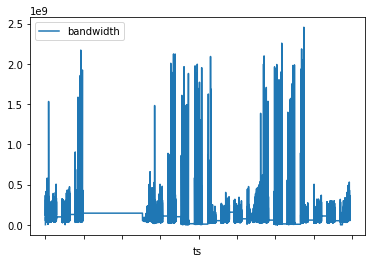

In [6]:
fig, ax = plt.subplots()
df_bw.plot(ax = ax);

## Reducing Data Set to 1 day

 The sample data set seems to be too large. We have data points per sec. Thus reducing the set to 1 TRADING DAY. 
 CST 8:00 AM - 5:00 PM

In [7]:
df_bw.head()

,bandwidth
ts,
2018-02-06 17:58:49+00:00,3270224
2018-02-06 17:58:50+00:00,63710864
2018-02-06 17:58:51+00:00,66147616
2018-02-06 17:58:52+00:00,82064232
2018-02-06 17:58:53+00:00,245525168


In [8]:
df_bw_one_trading_day = df_bw['2018-02-08 13:00:00+00:00':'2018-02-08 22:00:00+00:00']

In [9]:
df_bw_one_trading_day.head()

,bandwidth
ts,
2018-02-08 13:00:00+00:00,445100080
2018-02-08 13:00:01+00:00,253883032
2018-02-08 13:00:02+00:00,189334024
2018-02-08 13:00:03+00:00,246510904
2018-02-08 13:00:04+00:00,232703344


In [10]:
df_bw_one_trading_day.describe()['bandwidth'].apply(lambda x: '{:.2f}'.format(x))

count        32401.00
mean     128733486.49
std       14416871.43
min       49279984.00
25%      129634920.00
50%      129634920.00
75%      129634920.00
max      473851744.00
Name: bandwidth, dtype: object

In [11]:
df_bw_one_trading_day.loc[:, 'bandwidth'].median()

129634920.0

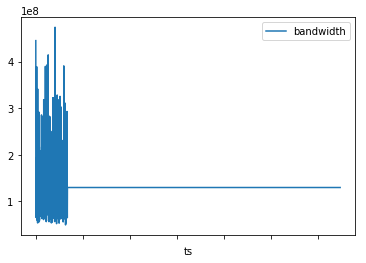

In [12]:
fig, ax = plt.subplots()
df_bw_one_trading_day.plot(ax = ax);

## Make an autocorrelation plot with statsmodels

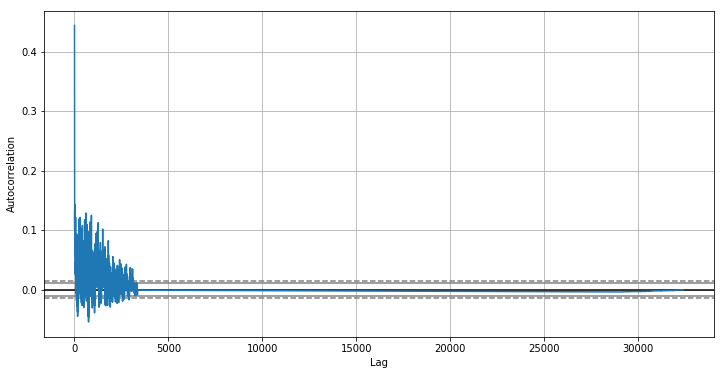

In [13]:
from pandas.plotting import autocorrelation_plot
fig,ax = plt.subplots(figsize=(12, 6))
autocorrelation_plot(df_bw_one_trading_day.loc[:, 'bandwidth'], ax=ax)

/Users/asahani/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


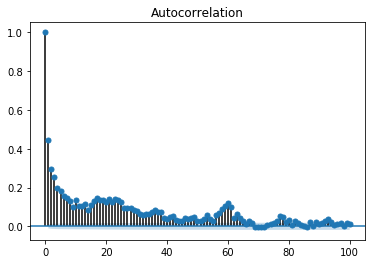

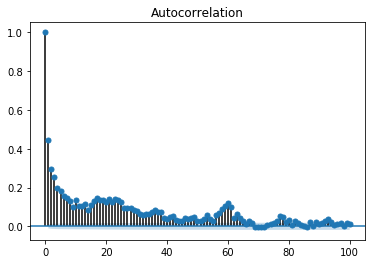

In [14]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

fig,ax = plt.subplots()
plot_acf(df_bw_one_trading_day.loc[:, 'bandwidth'], lags=100, ax=ax)

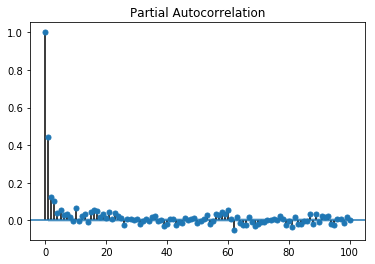

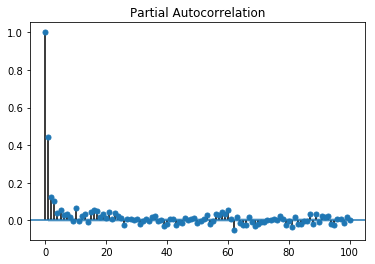

In [15]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

fig,ax = plt.subplots()
plot_pacf(df_bw_one_trading_day.loc[:, 'bandwidth'], lags=100, ax=ax)

We'll use the first two years (2010–2011) as the "training" data and the last year (2012) as a "testing" set.

In [16]:
df_bw_one_trading_day.head()

,bandwidth
ts,
2018-02-08 13:00:00+00:00,445100080
2018-02-08 13:00:01+00:00,253883032
2018-02-08 13:00:02+00:00,189334024
2018-02-08 13:00:03+00:00,246510904
2018-02-08 13:00:04+00:00,232703344


## Reducing 1 Day data set further to high volume trading period

High Volume trading Period is defined as CST 8:00 AM - 1:00 PM

In [17]:
df_bw_one_day_high_volume_timeperiod = df_bw['2018-02-08 13:00:00+00:00':'2018-02-08 18:00:00+00:00']

In [18]:
df_bw_one_day_high_volume_timeperiod.head()

,bandwidth
ts,
2018-02-08 13:00:00+00:00,445100080
2018-02-08 13:00:01+00:00,253883032
2018-02-08 13:00:02+00:00,189334024
2018-02-08 13:00:03+00:00,246510904
2018-02-08 13:00:04+00:00,232703344


In [19]:
df_bw_one_day_high_volume_timeperiod.describe()['bandwidth'].apply(lambda x: '{:.2f}'.format(x))

count        18001.00
mean     128012379.74
std       19311992.06
min       49279984.00
25%      129634920.00
50%      129634920.00
75%      129634920.00
max      473851744.00
Name: bandwidth, dtype: object

In [20]:
df_bw_one_day_high_volume_timeperiod.loc[:, 'bandwidth'].median()

129634920.0

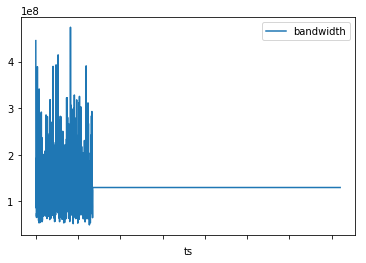

In [21]:
fig, ax = plt.subplots()
df_bw_one_day_high_volume_timeperiod.plot(ax = ax);

In [22]:
df_bw_one_day_high_volume_timeperiod.shape

(18001, 1)

In [23]:
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

lag_acf = acf(df_bw_one_day_high_volume_timeperiod, nlags=60)
lag_pacf = pacf(df_bw_one_day_high_volume_timeperiod, nlags=30, method='ols')

Text(0.5,1,'Autocorrelation Function')

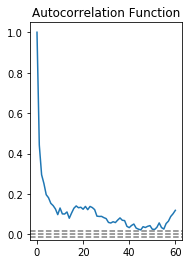

In [24]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_bw_one_day_high_volume_timeperiod)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_bw_one_day_high_volume_timeperiod)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

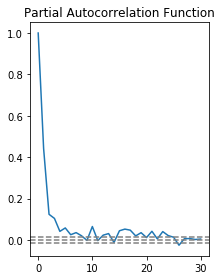

In [25]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_bw_one_day_high_volume_timeperiod)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_bw_one_day_high_volume_timeperiod)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# General explanation
Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. 
    Here the null hypothesis is that the TS is non-stationary. 
    The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. 
    If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 

In [26]:
## Dicky Fuller test the stationarity of time series.
# If data is not stationary then have to remove trend/seasnoality and fit the models on residuals.
    
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=30)
    rolstd = pd.rolling_std(timeseries, window=30)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:, 0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# Stationarity is defined using very strict criterion. However for practical purposes we can assume the series to be stationary if it has constant statistical properties over time ie. the following:

1) Constant Mean

2) Constant Variance

3) An autocovariance that does not depend on time.

/Users/asahani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=30,center=False).mean()
  
/Users/asahani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=30,center=False).std()
  if __name__ == '__main__':


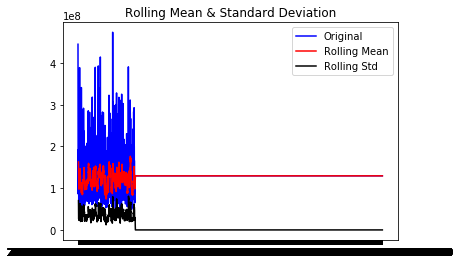

Results of Dickey-Fuller Test:
Test Statistic                -1.506902975e+01
p-value                        8.779591568e-28
#Lags Used                     4.400000000e+01
Number of Observations Used    1.795600000e+04
Critical Value (1%)           -3.430714237e+00
Critical Value (5%)           -2.861700979e+00
Critical Value (10%)          -2.566855685e+00
dtype: float64


In [27]:
test_stationarity(df_bw_one_day_high_volume_timeperiod)

# Test statistics is less then critical value -> rejecting null hypothesis i.e. series is stationary.

## For MODELS we are submitting 3 notebooks

1) Bandwidth_Analysis_Models

2) Bandwidth_Analysis_Prophet

3) Bandwidth_Analysis_Decision_Tree

## Conclusion

We are predicting next bandwidth spike in very short time period, to be specific in matters of couple of seconds.

This requires processing masive amount of data. As we can see from our EDA process, we have cleaned data to major extent. 

We added various business knowledge like focusing on high volume trading period.

We have done 3 models, results are satifactory but not whole lot useful, in the sense predicitons are not coming out great. Its for sure a good starting point.

However the work done here will be carried forward in our future work where we will make models to predict next bandwidth spike

# Future Work

1) We are Global compmany trading in exchanges across the globle. Thus time period of next bandwidth spike is also relative to which exchange we are talking about.

2) We will be breaking day worth of data into different buckets. Like CME / ICE trading in CST morning to noon. Eurex trading at CST night to early morning etc.

3) Mulitple models for given day

4) Convert bits to MBs 